# Fraud Detection Pipeline

An end-to-end fraud detection system built on the Sparkov synthetic transaction dataset (Kartik2112). The pipeline covers data exploration, behavioral feature engineering, XGBoost classification with SMOTE balancing, SHAP-based model explainability, and a pre-computed data export powering an interactive Streamlit dashboard.

---

**Dataset:** ~1.3M training / ~556K test transactions at a 0.58% fraud rate (1:172 class imbalance)

**Model:** XGBoost achieving 89.7% recall at the 0.50 probability threshold, catching 1,924 of 2,145 fraud cases

**Key finding:** Transaction amount is the dominant predictor (SHAP 2.57), followed by category risk and night-window timing. The model's blind spot is low-dollar fraud ($21.84 median) that mimics normal spending patterns.

**Outputs:** Serialized model, fitted scaler, pre-computed dashboard JSON, and a filtered transaction CSV — all feeding a 4-view Streamlit dashboard.

---

## 1.0 Environment & Data Ingestion

This section covers environment configuration and ingestion of the Sparkov-generated dataset (Kartik2112), establishing a verified data baseline for fraud analysis.

### 1.1 Configuration & Library Setup

In [1]:
# Standard library
import os
import json

# Data & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import shap

# Utilities
import joblib

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

c:\Users\Mike\anaconda3\envs\fraud-forensics\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Data Ingestion & Schema Validation

In [2]:
train_df = pd.read_csv('data/raw/fraudTrain.csv')
test_df = pd.read_csv('data/raw/fraudTest.csv')

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)
print()
train_df.head(3)

Training data shape: (1296675, 23)
Test data shape: (555719, 23)



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


## 2.0 Data Integrity & Initial Transformation

A standard integrity check verifies data completeness and class balance before feature engineering begins.

### 2.1 Missing Value & Duplicate Check

In [3]:
missing_count = train_df.isnull().sum().sum()
duplicate_count = train_df.duplicated().sum()

print(f'Missing Values: {missing_count}')
print(f'Duplicate Rows: {duplicate_count}')

# Class balance
fraud_ratio = train_df['is_fraud'].mean() * 100
fraud_count = train_df['is_fraud'].sum()
legit_count = len(train_df) - fraud_count
print(f'\nClass Balance:')
print(f'  Legitimate (0): {legit_count:,} ({100 - fraud_ratio:.2f}%)')
print(f'  Fraud (1):      {fraud_count:,} ({fraud_ratio:.2f}%)')
print(f'  Imbalance ratio: 1:{legit_count / fraud_count:.1f} (fraud:legitimate)')

if missing_count == 0 and duplicate_count == 0:
    print('\nData Integrity Confirmed: No anomalies detected.')

Missing Values: 0
Duplicate Rows: 0

Class Balance:
  Legitimate (0): 1,289,169 (99.42%)
  Fraud (1):      7,506 (0.58%)
  Imbalance ratio: 1:171.8 (fraud:legitimate)

Data Integrity Confirmed: No anomalies detected.


### 2.2 Temporal & Demographic Feature Derivation

In [4]:
# Convert datetime columns
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
train_df['dob'] = pd.to_datetime(train_df['dob'])

# Calculate age from transaction date and date of birth
train_df['age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days // 365

# Extract hour of day
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour

# Create age group bins
train_df['age_group'] = pd.cut(
    train_df['age'],
    bins=[0, 30, 50, 70, 120],
    labels=['<30', '30-50', '50-70', '70+']
)

print('Derived Features: Age, Hour, Age_Group created.')

Derived Features: Age, Hour, Age_Group created.


### 2.3 Category Consolidation & Renaming

The raw dataset contains 14 merchant categories, several of which represent the same transaction channel split across redundant labels.`shopping_net` and `misc_net`  represent online card-not-present purchases, while `shopping_pos` and `misc_pos` both represent in-store point-of-sale transactions.

These are consolidated into 12 distinct categories and renamed for clarity in downstream analysis and dashboard reporting. 

In [5]:
# Step 1: Consolidate overlapping channel categories
category_map = {
    'shopping_net': 'online_shopping',
    'misc_net':     'online_shopping',
    'shopping_pos': 'pos_shopping',
    'misc_pos':     'pos_shopping',
}

for df in [train_df, test_df]:
    df['category'] = df['category'].replace(category_map)

# Step 2: Rename to readable labels
readable_map = {
    'online_shopping': 'Online Shopping',
    'grocery_pos':     'Grocery (In-Store)',
    'grocery_net':     'Grocery (Online)',
    'pos_shopping':    'Retail (In-Store)',
    'gas_transport':   'Gas & Transport',
    'food_dining':     'Food & Dining',
    'health_fitness':  'Health & Fitness',
    'kids_pets':       'Kids & Pets',
    'personal_care':   'Personal Care',
    'entertainment':   'Entertainment',
    'home':            'Home',
    'travel':          'Travel',
}

for df in [train_df, test_df]:
    df['category'] = df['category'].replace(readable_map)

print(f"Categories after consolidation: {train_df['category'].nunique()}")
print(train_df['category'].value_counts().head(12))

Categories after consolidation: 12
category
Retail (In-Store)     196327
Online Shopping       160830
Gas & Transport       131659
Grocery (In-Store)    123638
Home                  123115
Kids & Pets           113035
Entertainment          94014
Food & Dining          91461
Personal Care          90758
Health & Fitness       85879
Grocery (Online)       45452
Travel                 40507
Name: count, dtype: int64


## 3.0 Exploratory Data Analysis

Exploratory analysis examining temporal patterns, demographic targeting, behavioral displacement, and geographic signals in the fraud data.

### 3.1 When: Temporal Signatures

This section examines how fraud distributes across hours of the day relative to legitimate transaction volume, testing whether off-peak hours show elevated fraud rates.

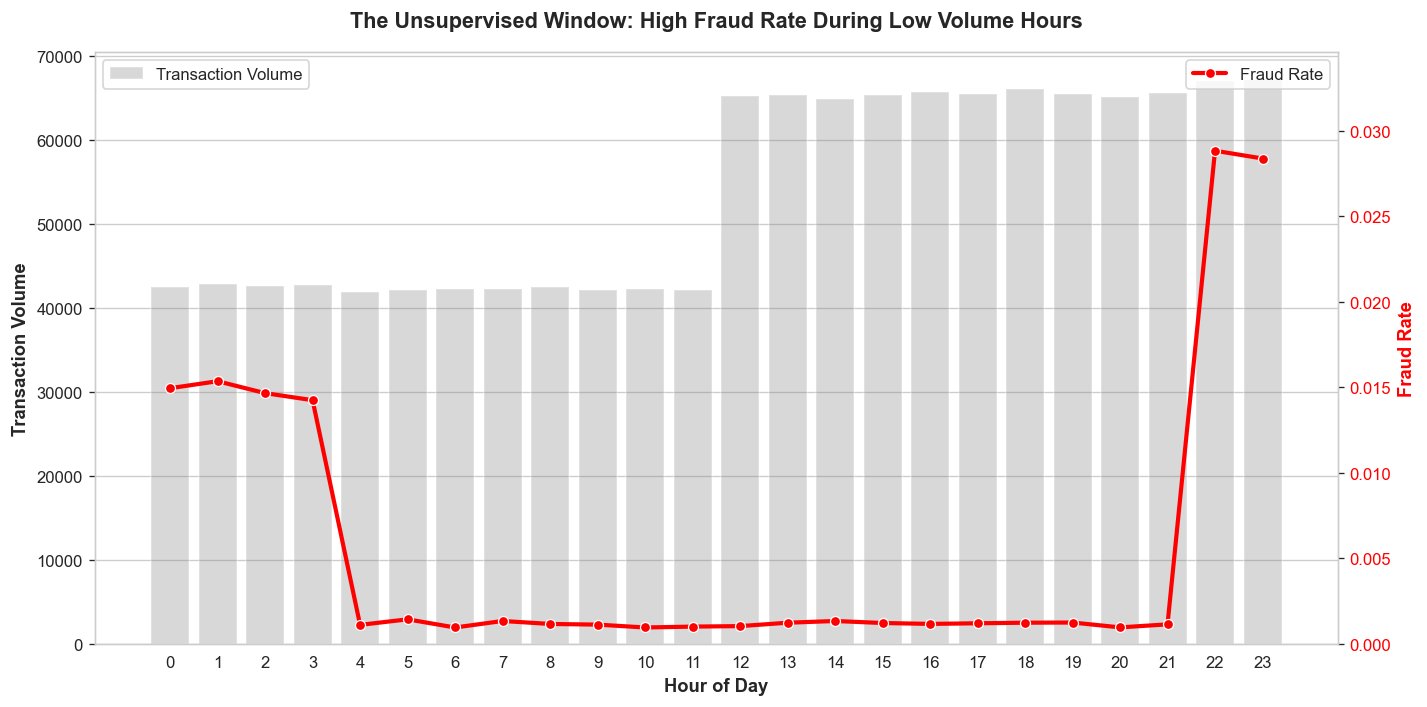

Peak fraud rate: Hour 22 (2.883%)
Peak transaction volume: Hour 23 (67,104 transactions)

Inverse relationship confirmed: High fraud rate during low volume hours.


In [6]:
hourly_stats = train_df.groupby('hour').agg(
    volume=('trans_num', 'count'),
    fraud_rate=('is_fraud', 'mean')
)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis: transaction volume (grey bars)
sns.barplot(
    x=hourly_stats.index, y=hourly_stats['volume'],
    alpha=0.3, color='grey', ax=ax1, label='Transaction Volume'
)
ax1.set_ylabel('Transaction Volume', fontsize=11, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')

# Secondary axis: fraud rate (red line)
ax2 = ax1.twinx()
sns.lineplot(
    x=hourly_stats.index, y=hourly_stats['fraud_rate'],
    color='red', marker='o', ax=ax2, label='Fraud Rate', linewidth=2.5
)
ax2.set_ylabel('Fraud Rate', fontsize=11, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, hourly_stats['fraud_rate'].max() * 1.2)

plt.title(
    'The Unsupervised Window: High Fraud Rate During Low Volume Hours',
    fontsize=13, fontweight='bold', pad=15
)
plt.grid(False)
fig.tight_layout()
plt.show()

peak_fraud_hour = hourly_stats['fraud_rate'].idxmax()
peak_volume_hour = hourly_stats['volume'].idxmax()
print(f'Peak fraud rate: Hour {peak_fraud_hour} ({hourly_stats.loc[peak_fraud_hour, "fraud_rate"]:.3%})')
print(f'Peak transaction volume: Hour {peak_volume_hour} ({hourly_stats.loc[peak_volume_hour, "volume"]:,} transactions)')
print(f'\nInverse relationship confirmed: High fraud rate during low volume hours.')

### 3.2 Who: Demographic Vulnerability

Fraud rate is cross-tabulated by age group and merchant category to identify whether specific demographic segments are disproportionately targeted.

C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\3852802270.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  age_cat_risk = train_df.pivot_table(


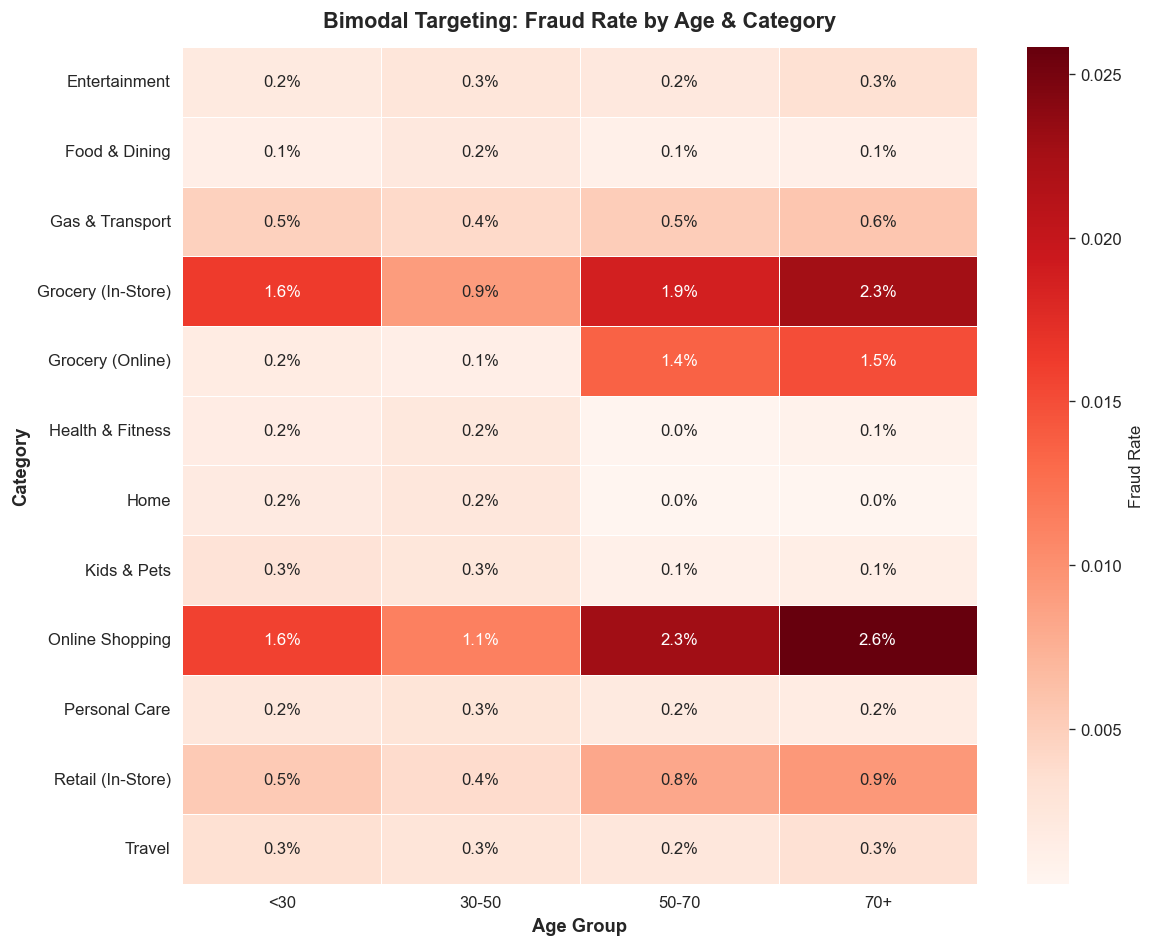

Top 10 Highest-Risk Age-Category Combinations:
  1. Online Shopping (70+): 2.58%
  2. Online Shopping (50-70): 2.28%
  3. Grocery (In-Store) (70+): 2.27%
  4. Grocery (In-Store) (50-70): 1.88%
  5. Grocery (In-Store) (<30): 1.63%
  6. Online Shopping (<30): 1.58%
  7. Grocery (Online) (70+): 1.50%
  8. Grocery (Online) (50-70): 1.35%
  9. Online Shopping (30-50): 1.13%
  10. Retail (In-Store) (70+): 0.94%


In [7]:
age_cat_risk = train_df.pivot_table(
    index='category', columns='age_group',
    values='is_fraud', aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    age_cat_risk, cmap='Reds', annot=True, fmt='.1%',
    cbar_kws={'label': 'Fraud Rate'}, linewidths=0.5
)
plt.title(
    'Bimodal Targeting: Fraud Rate by Age & Category',
    fontsize=13, fontweight='bold', pad=12
)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Category', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Print highest-risk combinations
print('Top 10 Highest-Risk Age-Category Combinations:')
age_cat_flat = age_cat_risk.stack().sort_values(ascending=False)
for idx, (cat_age, rate) in enumerate(age_cat_flat.head(10).items(), 1):
    print(f'  {idx}. {cat_age[0]} ({cat_age[1]}): {rate:.2%}')

### 3.3 How: Behavioral Displacement

The **Spending Spike Factor** measures each transaction's amount relative to the cardholder's historical average. A spike factor of 1.0 means the transaction matches the customer's typical spend; values significantly above 1.0 indicate anomalous spending behaviour — one of the most intuitive fraud signals available.

C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\3147631448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\3147631448.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Legitimate', 'Fraud'])


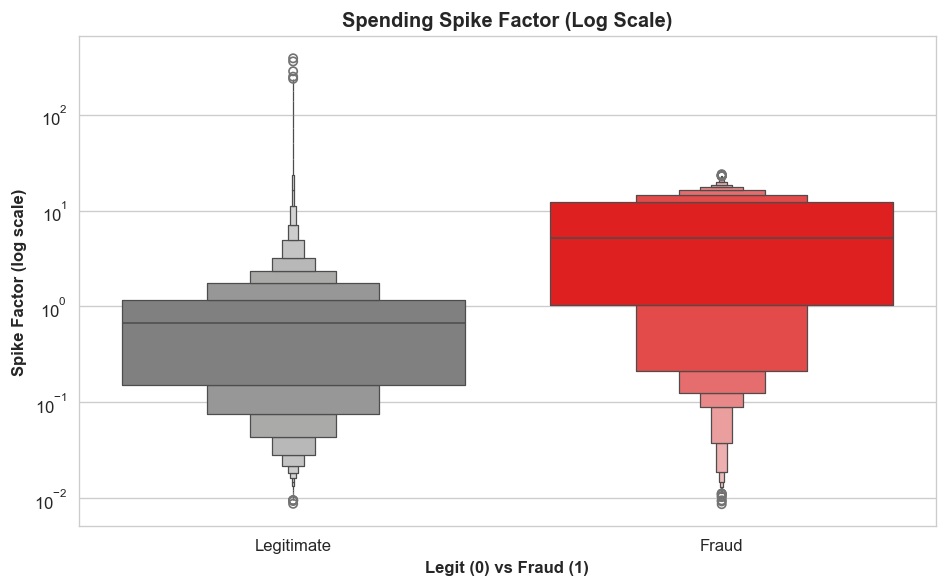

Spending Spike Analysis:
  Median spike (Legitimate): 0.67x
  Median spike (Fraud):      5.18x


In [8]:
# Spending spike factor: transaction amount relative to cardholder average
train_df['avg_card_amt'] = train_df.groupby('cc_num')['amt'].transform('mean')
train_df['spike_factor'] = train_df['amt'] / train_df['avg_card_amt']

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxenplot(
    data=train_df, x='is_fraud', y='spike_factor',
    ax=ax, palette=['grey', 'red']
)
ax.set_yscale('log')
ax.set_title('Spending Spike Factor (Log Scale)', fontsize=12, fontweight='bold')
ax.set_xlabel('Legit (0) vs Fraud (1)', fontsize=10, fontweight='bold')
ax.set_ylabel('Spike Factor (log scale)', fontsize=10, fontweight='bold')
ax.set_xticklabels(['Legitimate', 'Fraud'])
plt.tight_layout()
plt.show()

print('Spending Spike Analysis:')
print(f'  Median spike (Legitimate): {train_df[train_df["is_fraud"] == 0]["spike_factor"].median():.2f}x')
print(f'  Median spike (Fraud):      {train_df[train_df["is_fraud"] == 1]["spike_factor"].median():.2f}x')

The **Category Shift** indicator flags transactions in merchant categories the cardholder has never used before. A customer suddenly transacting in an unfamiliar category — especially one with a high baseline fraud rate — is a behavioural anomaly consistent with compromised credentials being tested across new merchant types.

C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\2260532139.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\2260532139.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Existing', 'New'])


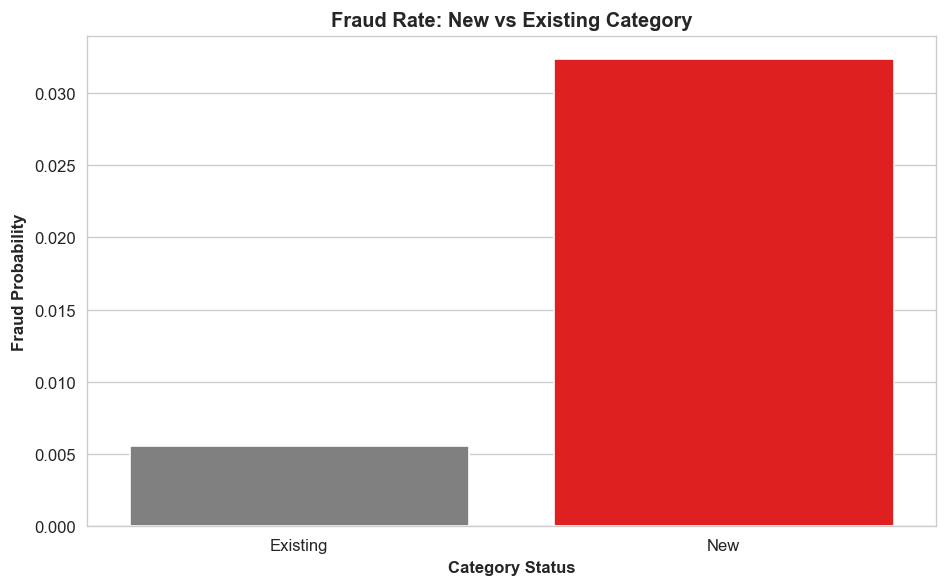

Category Shift Analysis:
  Fraud rate (Existing category): 0.5557%
  Fraud rate (New category):      3.2310%
  Risk multiplier: 5.81x


In [9]:
# Category shift: flag first-time category usage per cardholder
train_df = train_df.sort_values(['cc_num', 'trans_date_trans_time'])
train_df['cat_cumcount'] = train_df.groupby(['cc_num', 'category']).cumcount()
train_df['is_new_category'] = train_df['cat_cumcount'] == 0

category_fraud_rate = train_df.groupby('is_new_category')['is_fraud'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    x=[False, True], y=category_fraud_rate.values,
    ax=ax, palette=['grey', 'red']
)
ax.set_title('Fraud Rate: New vs Existing Category', fontsize=12, fontweight='bold')
ax.set_xlabel('Category Status', fontsize=10, fontweight='bold')
ax.set_ylabel('Fraud Probability', fontsize=10, fontweight='bold')
ax.set_xticklabels(['Existing', 'New'])
plt.tight_layout()
plt.show()

print('Category Shift Analysis:')
print(f'  Fraud rate (Existing category): {category_fraud_rate[False]:.4%}')
print(f'  Fraud rate (New category):      {category_fraud_rate[True]:.4%}')
print(f'  Risk multiplier: {category_fraud_rate[True] / category_fraud_rate[False]:.2f}x')

### 3.4 Where: Geospatial Assessment

A detailed analysis in geospatial_neutrality_report.ipynb confirms that geospatial features (coordinates, state, city_pop) are statistically neutral in this dataset:

- **State Targeting:** r ≈ 1.0 — fraud is uniformly distributed across all states.
- **Velocity:** Zero recall on travelers with impossible speeds (>100 km/h) — the attack vector is digital/remote.
- **Population Density:** No distinction between urban and rural targeting — distributions overlap completely.

**Decision:** Geospatial features are excluded from the primary modeling pipeline to prevent noise injection. The model will focus exclusively on behavioral and temporal signals that demonstrate discriminatory power in this synthetic dataset.

## 4.0 Feature Engineering: Behavioral Baseline Construction

The feature engineering pipeline is applied to both training and test sets. Age and cyclical time features are derived first to satisfy downstream dependencies.

### 4.1 Temporal & Cyclical Features

Hour-of-day indicators, the binary night window flag, and cyclical sine/cosine encodings are derived for both training and test sets.

In [10]:
dfs = [train_df, test_df]

for i, df in enumerate(dfs):
    # Datetime conversion (both timestamp and dob)
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    # Age derivation (must precede downstream age_group mapping)
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # Chronological sort
    df.sort_values(['cc_num', 'trans_date_trans_time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Temporal features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['is_night_window'] = df['hour'].isin([22, 23, 0, 1, 2, 3]).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

### 4.2 Behavioral Patterns (Zero-Leakage)

Card-level baselines are constructed using strictly past-facing windows to prevent look-ahead bias. The same logic is applied to both train and test sets.

In [11]:
for i, df in enumerate(dfs):
    # Time since last transaction (seconds)
    df['time_since_last'] = (
        df.groupby('cc_num')['trans_date_trans_time']
        .diff().dt.total_seconds().fillna(0)
    )

    cat_counts = df.groupby(['cc_num', 'category']).cumcount()
    card_history_index = df.groupby('cc_num').cumcount()

    # "New Category" if it's the 1st time for the category
    # AND it's at least the 11th transaction for that cc.
    df['is_new_category'] = ((cat_counts == 0) & (card_history_index >= 10)).astype(int)

    # Spike factor (expanding median, shifted to exclude current row)
    df.drop(columns=['spike_factor', 'avg_card_amt'], errors='ignore', inplace=True)
    expanding_med = (
        df.groupby('cc_num')['amt']
        .expanding().median()
        .groupby(level=0).shift(1)
        .reset_index(level=0, drop=True)
    )
    df['spike_factor'] = (df['amt'] / expanding_med).fillna(1.0)

print("Behavioral baselines computed: time_since_last, is_new_category, spike_factor")

Behavioral baselines computed: time_since_last, is_new_category, spike_factor


#### 4.2.1 Velocity Windows

Rolling transaction counts over 24-hour, 7-day, and 30-day windows capture acceleration patterns. The burst ratio normalizes short-term velocity against the monthly baseline.

In [12]:
for i, df in enumerate(dfs):
    # Velocity windows (closed='left' excludes current transaction)
    df.set_index('trans_date_trans_time', inplace=True)

    df['trans_count_24h'] = (
        df.groupby('cc_num')['amt']
        .rolling('24h', closed='left').count()
        .reset_index(level=0, drop=True)
    )
    df['trans_count_7d'] = (
        df.groupby('cc_num')['amt']
        .rolling('7D', closed='left').count()
        .reset_index(level=0, drop=True)
    )
    df['trans_count_30d'] = (
        df.groupby('cc_num')['amt']
        .rolling('30D', closed='left').count()
        .reset_index(level=0, drop=True)
    )

    # Velocity burst ratio (+1 smoothing prevents division by zero)
    df['velocity_burst_24h'] = (
        df['trans_count_24h'] / ((df['trans_count_30d'] / 30) + 1)
    )

    df.reset_index(inplace=True)
    dfs[i] = df

train_df, test_df = dfs

print("Velocity windows computed: trans_count_24h, trans_count_7d, trans_count_30d, velocity_burst_24h")

Velocity windows computed: trans_count_24h, trans_count_7d, trans_count_30d, velocity_burst_24h


### 4.3 Demographic Binning & Column Cleanup

The derived age feature is mapped to demographic bins, and raw geospatial columns and personal identifiers are dropped to reduce noise and prevent leakage.

In [13]:
drop_cols = [
    'lat', 'long', 'merch_lat', 'merch_long', 'state', 'zip', 'city_pop',
    'first', 'last', 'street', 'city', 'job', 'trans_num', 'unix_time',
    'dob', 'age',
]

for df in [train_df, test_df]:
    df['age_group'] = pd.cut(
        df['age'], bins=[0, 30, 50, 70, 120],
        labels=['<30', '30-50', '50-70', '70+']
    )
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

### 4.4 Leakage Verification & Dimensions

Verification of the Zero-Leakage Protocol and dataset dimensions.

In [14]:
print(f'train_df: {train_df.shape}')
print(f'test_df:  {test_df.shape}')

# Audit a single cardholder's history
card_counts = train_df.groupby('cc_num').size()
eligible_cards = card_counts[card_counts > 10].index
np.random.seed(42)
audit_card = np.random.choice(eligible_cards)

audit_cols = ['trans_date_trans_time', 'age_group', 'spike_factor', 'trans_count_7d']
audit_df = train_df.loc[train_df['cc_num'] == audit_card, audit_cols].head(5)

print(f'\nLeakage Check \u2014 Card: {audit_card}')
print(audit_df.to_string(index=False))

train_df: (1296675, 21)
test_df:  (555719, 20)

Leakage Check — Card: 4471568287204
trans_date_trans_time age_group  spike_factor  trans_count_7d
  2019-01-01 05:12:31       70+      1.000000             NaN
  2019-01-02 02:50:22       70+      0.413875             1.0
  2019-01-04 08:59:54       70+      1.011447             2.0
  2019-01-04 13:30:58       70+      0.740304             3.0
  2019-01-05 02:45:55       70+      6.708853             4.0


### 4.5 Removing Intermediate Columns

In [15]:
investigative_artifacts = [
    'cat_cumcount', 
    'avg_card_amt', 
    'hour' 
]

for df in [train_df, test_df]:
    df.drop(columns=investigative_artifacts, inplace=True, errors='ignore')

print("Intermediate columns removed.")

Intermediate columns removed.


## 5.0 Preprocessing & Class Balancing

Data preparation includes feature/target separation, risk-based categorical encoding, and numerical standardization. The pre-split test set ensures strict train/test isolation.

### 5.1 Feature Selection, Split & Neutral Imputation

Features are separated from targets, and cold-start NaN values from lag features are imputed with neutral defaults: 1.0 for ratios (no deviation from baseline) and 0 for historical counts.

In [16]:
# Separate targets
y_train = train_df['is_fraud']
y_test = test_df['is_fraud']

# Define features (drop identifiers, target, and redundant linear hour)
drop_cols = ['is_fraud', 'cc_num', 'trans_date_trans_time', 'hour']
if 'Unnamed: 0' in train_df.columns:
    drop_cols.append('Unnamed: 0')

X_train = train_df.drop(columns=drop_cols, errors='ignore')
X_test = test_df.drop(columns=drop_cols, errors='ignore')

# Cold-start NaNs arise from lag features (e.g., first transaction
# for a cardholder has no prior history). Starting ratios are set to 1.0 (no deviation from self),
# counts to 0 (no prior activity observed).
fill_vals = {
    'spike_factor': 1.0,
    'time_since_last': 0,
    'trans_count_7d': 0,
    'trans_count_24h': 0,
    'trans_count_30d': 0,
    'velocity_burst_24h': 0
}
X_train.fillna(value=fill_vals, inplace=True)
X_test.fillna(value=fill_vals, inplace=True)

# Validate clean matrix before scaling
assert X_train.isna().sum().sum() == 0, "X_train contains NaN values before scaling"
assert X_test.isna().sum().sum() == 0, "X_test contains NaN values before scaling"

print(f"Features: {X_train.shape[1]} | Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"NaN check — Train: {X_train.isna().sum().sum()} | Test: {X_test.isna().sum().sum()}")

Features: 15 | Train: 1296675 | Test: 555719
NaN check — Train: 0 | Test: 0


### 5.2 Risk-Based Target Encoding

High-cardinality features (`merchant`, `category`) are converted into numerical risk scores based on their mean fraud rate in the training set. Unseen categories in the test set are imputed with the global training fraud mean to prevent leakage.

In [17]:
global_mean = y_train.mean()

for col in ['merchant', 'category']:
    # Calculate risk mapping from training data only
    risk_map = y_train.groupby(X_train[col]).mean()

    # Map to both sets
    X_train[f'{col}_risk'] = X_train[col].map(risk_map)
    X_test[f'{col}_risk'] = X_test[col].map(risk_map).fillna(global_mean)

    # Remove original strings
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

print(f"Encoded features: merchant_risk, category_risk")
print(f"Remaining columns: {list(X_train.columns)}")

Encoded features: merchant_risk, category_risk
Remaining columns: ['amt', 'gender', 'age_group', 'is_new_category', 'is_night_window', 'hour_sin', 'hour_cos', 'time_since_last', 'spike_factor', 'trans_count_24h', 'trans_count_7d', 'trans_count_30d', 'velocity_burst_24h', 'merchant_risk', 'category_risk']


### 5.3 Demographic Ordinal & Binary Mapping

Convert demographic descriptors into numerical formats. Gender is binary encoded, and age groups are mapped to ordinal integers to preserve the life-stage hierarchy identified during exploratory analysis.

In [18]:
# Binary mapping
X_train['gender'] = X_train['gender'].map({'M': 0, 'F': 1})
X_test['gender'] = X_test['gender'].map({'M': 0, 'F': 1})

# Ordinal mapping
age_map = {'<30': 0, '30-50': 1, '50-70': 2, '70+': 3}
X_train['age_group'] = X_train['age_group'].map(age_map).astype(int)
X_test['age_group'] = X_test['age_group'].map(age_map).astype(int)

print("Demographic encoding complete: gender (binary), age_group (ordinal)")

Demographic encoding complete: gender (binary), age_group (ordinal)


### 5.4 Feature Standardization

Normalize numerical distributions using `StandardScaler`. The scaler is fitted exclusively on the training features to ensure the test set remains an unbiased proxy for real-world inference.

In [19]:
# Ensure identical column order
X_test = X_test[X_train.columns]

scaler = StandardScaler()
cols = X_train.columns

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols, index=X_test.index)

### 5.5 Class Balancing (SMOTE)

SMOTE (Synthetic Minority Over-sampling Technique) addresses the extreme class imbalance (0.58% fraud) by oversampling the minority class in the training set, reinforcing the decision boundary around fraudulent patterns to improve recall.

In [20]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class balance after SMOTE:")
print(y_train_res.value_counts(normalize=True))

Class balance after SMOTE:
is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


### 5.6 Final Preprocessing Verification

Final audit of the transformed matrix dimensions prior to model training.

In [21]:
print(f"Resampled Train Shape: {X_train_res.shape}")
print(f"Original Test Shape:    {X_test.shape}")

Resampled Train Shape: (2578338, 15)
Original Test Shape:    (555719, 15)


## 6.0 Model Benchmarking & Selection

A naive stratified baseline is established first, then compared against the XGBoost model to quantify the performance lift — the specific reduction in missed fraud achieved by the model over random classification.

### 6.1 Naive Baseline Construction

A Stratified Dummy Classifier simulates random-guess performance proportional to the class distribution, establishing the minimum performance floor.

In [22]:
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train_res, y_train_res)
y_pred_dummy = dummy.predict(X_test)

fn_dummy = int(confusion_matrix(y_test, y_pred_dummy).ravel()[2])
print(f"Dummy Classifier — Missed Cases (FN): {fn_dummy}")

Dummy Classifier — Missed Cases (FN): 1057


### 6.2 Champion Model Configuration

The Champion Model utilizes the XGBoost gradient boosting architecture. Hyperparameters were selected through iterative experimentation, prioritizing recall (minimizing False Negatives) while maintaining a manageable false alarm rate for the review queue.

In [ ]:
champion_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    gamma=0.2,
    random_state=42,
    n_jobs=5
)
champion_model.fit(X_train_res, y_train_res)
y_pred_xgb = champion_model.predict(X_test)

print("Champion model training complete.")

c:\Users\Mike\anaconda3\envs\fraud-forensics\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Champion model training complete.


### 6.3 Performance Lift Report

The raw missed fraud counts are compared between baseline and champion model. The delta represents the tangible value added by the algorithmic approach.

ADVISORY LIFT REPORT
Baseline Missed Cases (Leakage): 1057
Champion Missed Cases (Leakage): 221
Advisory Lift (Transactions Saved): 836


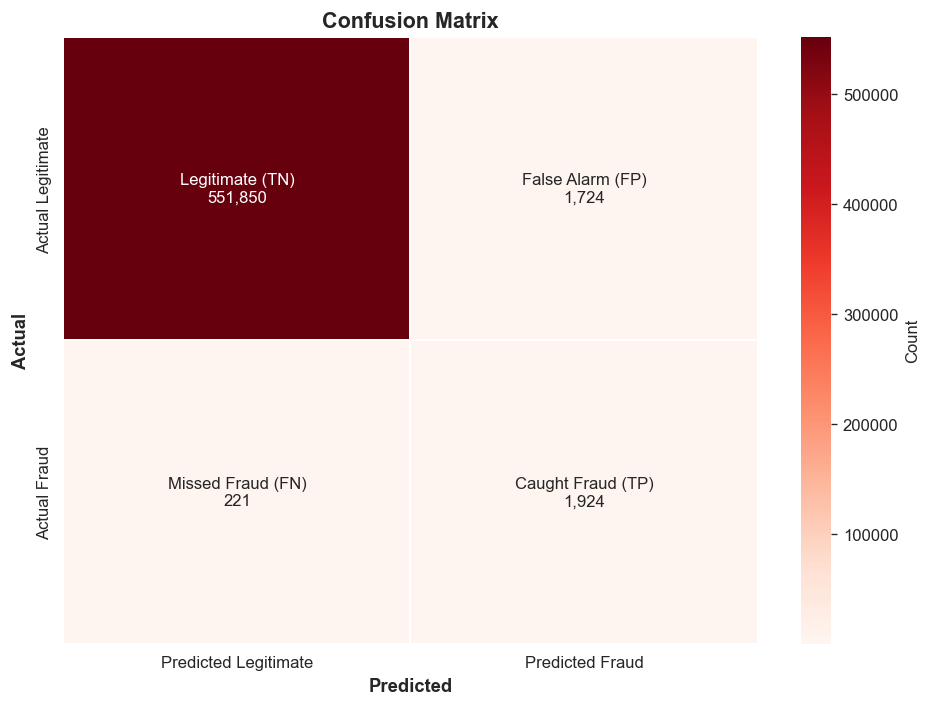

In [24]:
fn_xgb = int(confusion_matrix(y_test, y_pred_xgb).ravel()[2])

print("=" * 55)
print("ADVISORY LIFT REPORT")
print("=" * 55)
print(f"Baseline Missed Cases (Leakage): {fn_dummy}")
print(f"Champion Missed Cases (Leakage): {fn_xgb}")
print(f"Advisory Lift (Transactions Saved): {fn_dummy - fn_xgb}")
print("=" * 55)

# Investigative Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()

labels = np.array([
    [f'Legitimate (TN)\n{tn:,}', f'False Alarm (FP)\n{fp:,}'],
    [f'Missed Fraud (FN)\n{fn:,}', f'Caught Fraud (TP)\n{tp:,}']
])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=labels, fmt='', cmap='Reds',
    xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
    yticklabels=['Actual Legitimate', 'Actual Fraud'],
    linewidths=1, cbar_kws={'label': 'Count'}, ax=ax
)
ax.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 7.0 Operational Calibration

Model probabilities must be converted into binary decisions using a threshold that balances fraud coverage against false alarm volume. The precision-recall trade-off is analyzed across multiple thresholds.

### 7.1 Precision-Recall Analysis

The precision-recall curve is computed across all thresholds. The 0.5 probability threshold is selected as the operating point, capturing the majority of fraud without generating an unmanageable volume of false alarms.

In [25]:
y_proba_xgb = champion_model.predict_proba(X_test)[:, 1]
threshold_sweep_data = []
for t in [0.40, 0.45, 0.5, 0.55, 0.6]:
    preds = (y_proba_xgb > t).astype(int)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    flagged = preds.sum()
    threshold_sweep_data.append([t, rec, prec, int(flagged)])
    print(f"t={t:.2f}  Recall={rec:.3%}  Precision={prec:.3%}  Flagged={flagged:,}")

t=0.40  Recall=91.515%  Precision=44.452%  Flagged=4,416
t=0.45  Recall=90.583%  Precision=48.709%  Flagged=3,989
t=0.50  Recall=89.697%  Precision=52.741%  Flagged=3,648
t=0.55  Recall=88.438%  Precision=57.259%  Flagged=3,313
t=0.60  Recall=87.646%  Precision=61.781%  Flagged=3,043


**Threshold Selection Rationale:**

At t=0.50 the model flags 3,648 transactions for review, catching 89.7% of fraud with 52.7% precision — meaning roughly 1 in 2 flagged transactions is confirmed fraud. This represents a manageable review workload.

- **Lowering to t=0.40** adds 768 more alerts (+21%) but captures only 1.8% more fraud. The marginal cost per additional caught fraud case is ~42 extra false alarms per true positive gained — an unfavourable trade-off for a human review queue.
- **Raising to t=0.55** removes 335 alerts but sacrifices 1.3% recall, letting approximately 27 additional fraud cases slip through undetected.

The t=0.50 threshold is selected as the **Operational Sweet Spot**, balancing investigator capacity against fraud coverage.

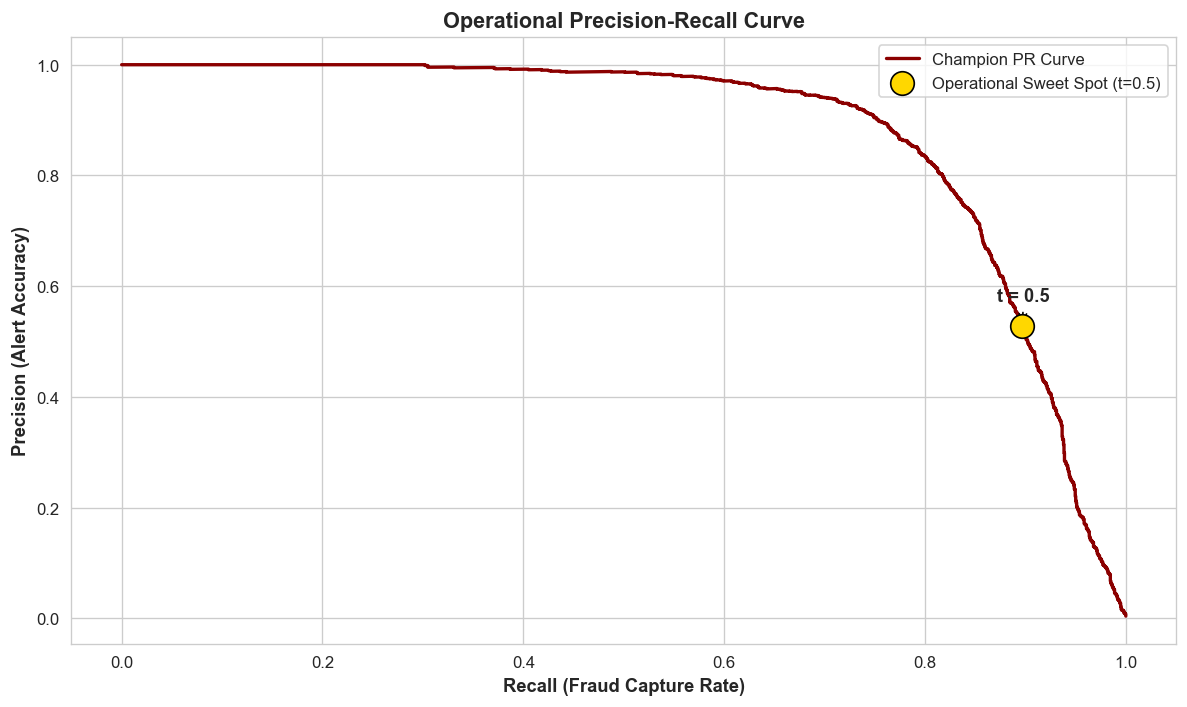

In [26]:
prec_curve, rec_curve, pr_thresholds = precision_recall_curve(y_test, y_proba_xgb)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rec_curve, prec_curve, color='darkred', linewidth=2, label='Champion PR Curve')

# Mark the 0.5 threshold operating point
prec_at_05 = precision_score(y_test, y_pred_xgb)
rec_at_05 = recall_score(y_test, y_pred_xgb)
ax.scatter(rec_at_05, prec_at_05, s=200, color='gold', edgecolors='black',
           zorder=45, label='Operational Sweet Spot (t=0.5)')
ax.annotate('t = 0.5', (rec_at_05, prec_at_05),
            textcoords="offset points", xytext=(-15, 15),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='black'))

ax.set_xlabel('Recall (Fraud Capture Rate)', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision (Alert Accuracy)', fontsize=11, fontweight='bold')
ax.set_title('Operational Precision-Recall Curve', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### 7.2 Missed Case Analysis

Despite high recall, 221 fraud cases remain undetected. This section profiles those missed cases to characterize the model's blind spots and inform future improvements.

In [27]:
blind_spots = X_test[(y_test.values == 1) & (y_pred_xgb == 0)].copy()

# Join raw amount and category from original test set for interpretability
blind_spots['amt_raw'] = test_df.loc[blind_spots.index, 'amt'].values
blind_spots['category_raw'] = test_df.loc[blind_spots.index, 'category'].values

median_missed_amt = blind_spots['amt_raw'].median()

# Category breakdown of missed fraud
missed_by_category = blind_spots['category_raw'].value_counts()

# category_risk is the target-encoded risk score; bucket into quintiles
blind_spots['risk_band'] = pd.qcut(
    blind_spots['category_risk'], q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    duplicates='drop'
)
top_risk_bands = blind_spots['risk_band'].value_counts().head(3)

print("=" * 55)
print("RESIDUAL RISK AUDIT — BLIND SPOTS")
print("=" * 55)
print(f"Undetected Fraud Count:        {len(blind_spots)}")
print(f"Median Transaction Amount:     ${median_missed_amt:.2f}")
print(f"\nMissed Fraud by Category (Top 5):")
for cat, count in missed_by_category.head(5).items():
    print(f"  {cat}: {count} ({count/len(blind_spots):.1%})")
print(f"\nTop 3 Category Risk Bands in Missed Cases:")
for band, count in top_risk_bands.items():
    print(f"  {band}: {count} ({count/len(blind_spots):.1%})")
print("=" * 55)

RESIDUAL RISK AUDIT — BLIND SPOTS
Undetected Fraud Count:        221
Median Transaction Amount:     $21.84

Missed Fraud by Category (Top 5):
  Personal Care: 37 (16.7%)
  Retail (In-Store): 32 (14.5%)
  Travel: 29 (13.1%)
  Food & Dining: 28 (12.7%)
  Health & Fitness: 25 (11.3%)

Top 3 Category Risk Bands in Missed Cases:
  High: 71 (32.1%)
  Very Low: 69 (31.2%)
  Medium: 44 (19.9%)


## 8.0 Model Explainability (SHAP)

SHAP (SHapley Additive exPlanations) provides feature-level interpretability, ensuring model decisions are transparent and driven by meaningful behavioral signals rather than noise or artifacts.

C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\1206659249.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type='bar', show=False)


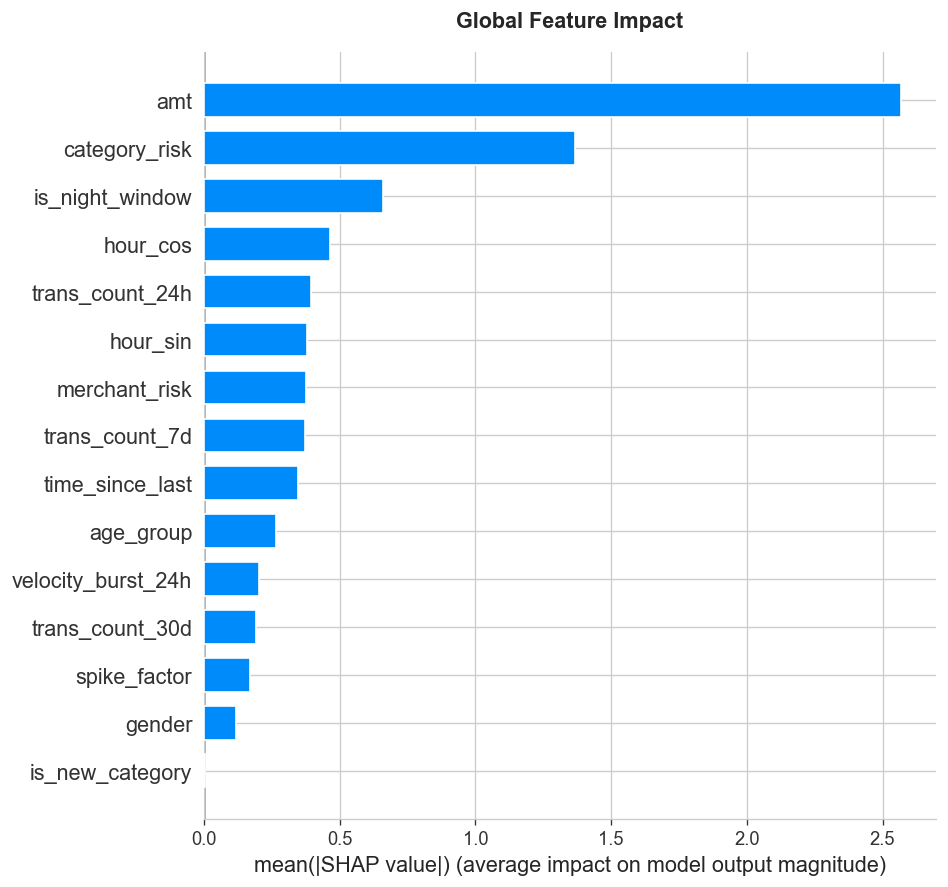


SHAP Importance (top 5):
  amt: 2.5682
  category_risk: 1.3668
  is_night_window: 0.6603
  hour_cos: 0.4657
  trans_count_24h: 0.3943


In [28]:
# Efficiency Constraint: Sample 5,000 rows to prevent explainer timeouts.
X_shap = shap.utils.sample(X_test, 5000, random_state=42)

explainer = shap.TreeExplainer(champion_model)
shap_values = explainer.shap_values(X_shap)

# Pre-compute mean |SHAP| per feature for dashboard export (sorted descending)
shap_importance_dict = dict(sorted(
    zip(X_shap.columns, np.abs(shap_values).mean(axis=0)),
    key=lambda x: x[1], reverse=True
))

plt.figure()
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=False)
plt.title('Global Feature Impact', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nSHAP Importance (top 5):")
for feat, val in list(shap_importance_dict.items())[:5]:
    print(f"  {feat}: {val:.4f}")

### 8.1 Directional Feature Impact (Beeswarm)

While the bar chart above shows the *magnitude* of each feature's impact, the beeswarm plot reveals the *direction*. Each dot is a single prediction from the SHAP sample. Dots pushed right increase fraud probability; dots pushed left decrease it. The colour encodes the feature's raw value (red = high, blue = low).

Key observations:
- **High transaction amounts** (`amt`) consistently push predictions toward fraud (red dots on the right).
- **High category risk scores** amplify fraud probability, confirming that certain merchant categories carry systemic exposure.
- **Night window = 1** (red dots) clusters strongly to the right, validating the temporal attack surface identified in the EDA.

C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\4151961246.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, show=False)


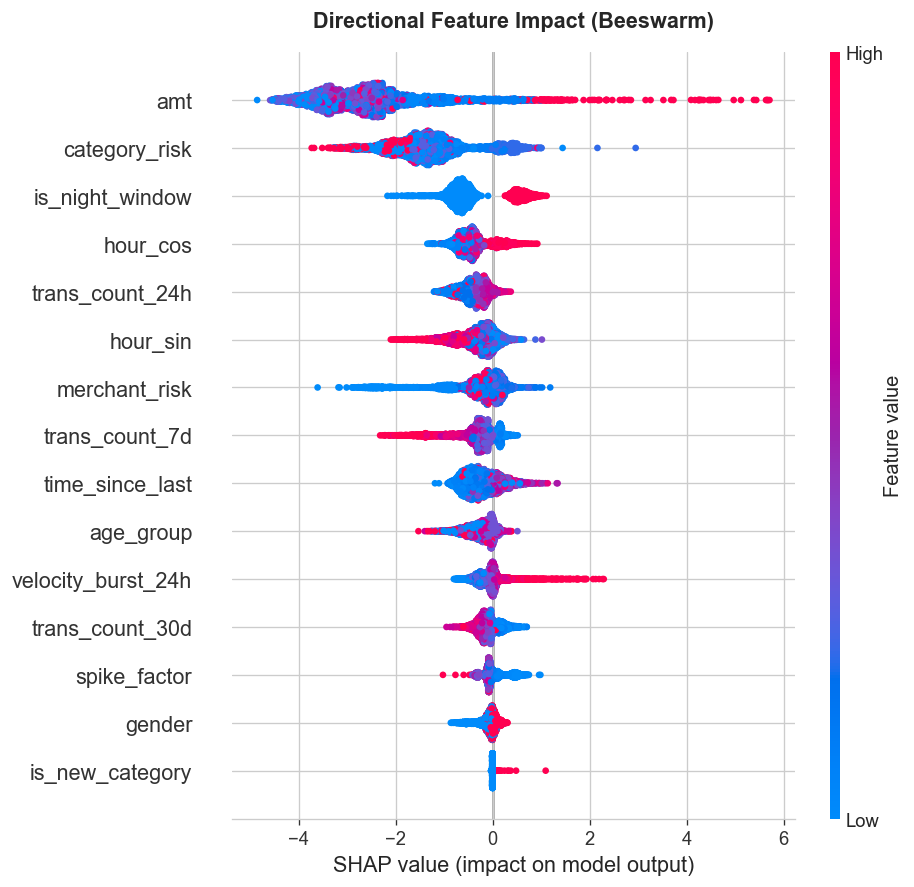

In [29]:
plt.figure()
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('Directional Feature Impact (Beeswarm)', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### 8.2 Case Study: Anatomy of a Detected Fraud

To demonstrate per-prediction explainability, a single high-confidence true positive is isolated — a transaction the model flagged as fraud with near-certainty — and its risk score is decomposed into individual feature contributions. This is the level of granularity expected when a specific model decision needs to be justified or challenged.

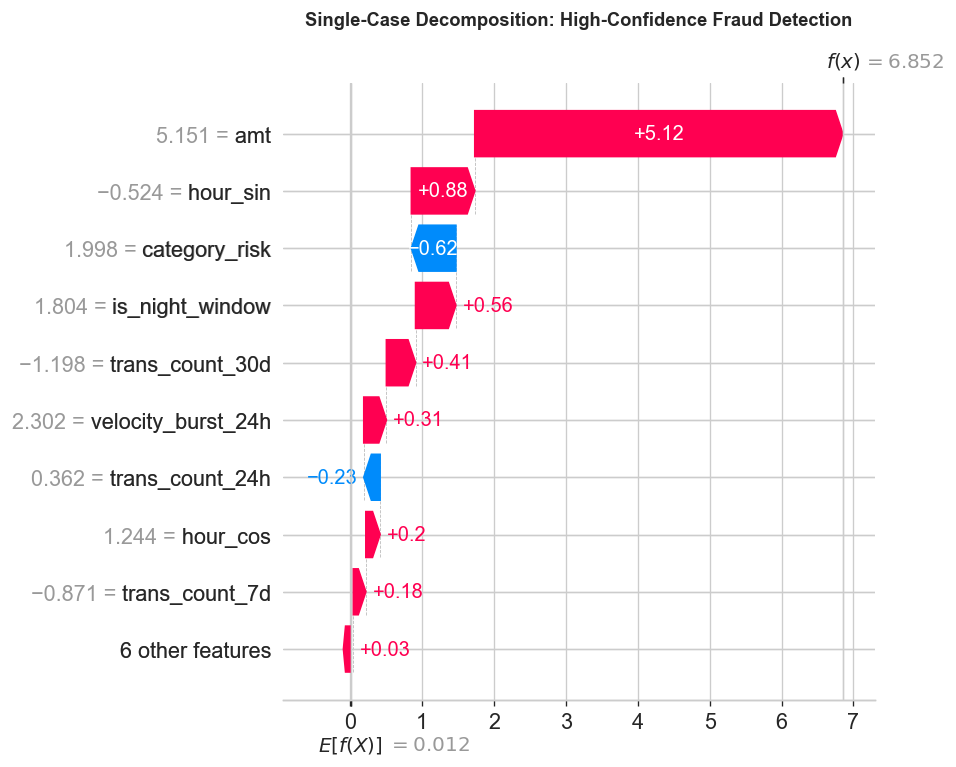

Model confidence for this transaction: 0.9989
Actual label: Fraud (1)


In [30]:
# Find the true positive with the highest model confidence
y_proba_shap = champion_model.predict_proba(X_shap)[:, 1]
tp_mask = (y_test.loc[X_shap.index].values == 1) & (y_proba_shap > 0.5)
tp_indices = np.where(tp_mask)[0]

# Select the highest-confidence TP
best_tp_idx = tp_indices[np.argmax(y_proba_shap[tp_indices])]

explanation = shap.Explanation(
    values=shap_values[best_tp_idx],
    base_values=explainer.expected_value,
    data=X_shap.iloc[best_tp_idx].values,
    feature_names=X_shap.columns.tolist()
)

plt.figure()
shap.waterfall_plot(explanation, show=False)
plt.title('Single-Case Decomposition: High-Confidence Fraud Detection', fontsize=11, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print(f"Model confidence for this transaction: {y_proba_shap[best_tp_idx]:.4f}")
print(f"Actual label: Fraud (1)")

The waterfall shows how the model's base expectation (the average log-odds across all predictions) is pushed toward the fraud classification by a stack of individual feature contributions. This case-level transparency satisfies the 'Right to Explanation' framework — every flagged transaction can be accompanied by a human-readable breakdown of *why* it was flagged.

## 9.0 Production Asset Export

To keep the dashboard responsive, key assets are pre-calculated and serialized. This decouples heavy analytical processing from the real-time user interface.

### 9.1 Dependency Setup

In [31]:
os.makedirs('dashboard_data', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("Target directories verified: dashboard_data/, models/")

Target directories verified: dashboard_data/, models/


### 9.2 Dashboard Data Export (Transaction Explorer)

Streaming 500k+ transactions to a dashboard creates latency. The export filters to all high-risk transactions (risk score > 0.1) plus a random sample of legitimate traffic for context.

In [32]:
y_proba = champion_model.predict_proba(X_test)[:, 1]

# Inverse-transform scaled features to recover raw values for human-readable columns
X_test_raw = pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns, index=X_test.index)

# Create the export dataframe with both features and human-readable context
export_df = X_test.copy()
export_df['risk_score'] = y_proba
export_df['is_fraud'] = y_test.values

# JOIN the original category and merchant strings back in for the UI
export_df['category'] = test_df['category'].values
export_df['amt'] = test_df['amt'].values

# Add human-readable (unscaled) columns for the Transaction Auditor view
export_df['age_group_label'] = X_test_raw['age_group'].round().astype(int).map(
    {0: '<30', 1: '30-50', 2: '50-70', 3: '70+'}
)
export_df['spike_factor_raw'] = X_test_raw['spike_factor']
export_df['is_night_window_raw'] = X_test_raw['is_night_window'].round().astype(int)
export_df['velocity_burst_24h_raw'] = X_test_raw['velocity_burst_24h']

# Filter for the dashboard
high_risk = export_df[export_df['risk_score'] > 0.1]
context_sample = export_df[export_df['risk_score'] <= 0.1].sample(n=5000, random_state=42)

export_df_final = pd.concat([high_risk, context_sample])
export_df_final.to_csv('dashboard_data/investigative_results.csv', index=False)

print(f"Exported {len(export_df_final):,} rows to investigative_results.csv")
print(f"Columns: {list(export_df_final.columns)}")

Exported 17,998 rows to investigative_results.csv
Columns: ['amt', 'gender', 'age_group', 'is_new_category', 'is_night_window', 'hour_sin', 'hour_cos', 'time_since_last', 'spike_factor', 'trans_count_24h', 'trans_count_7d', 'trans_count_30d', 'velocity_burst_24h', 'merchant_risk', 'category_risk', 'risk_score', 'is_fraud', 'category', 'age_group_label', 'spike_factor_raw', 'is_night_window_raw', 'velocity_burst_24h_raw']


### 9.3 Dashboard KPI & Chart Data

High-level KPIs, chart aggregations, and derived metrics are pre-calculated for instant dashboard loading.

In [33]:
# --- KPI Calculation ---
total_trans = len(X_test)
flagged_trans = int((y_proba > 0.5).sum())
caught_fraud = int(((y_test == 1) & (y_proba > 0.5)).sum())
missed_fraud = int(((y_test == 1) & (y_proba <= 0.5)).sum())

# --- Chart Data (V1) ---
fraud_by_category = (
    test_df.loc[y_test == 1, 'category']
    .value_counts()
    .head(10)
    .to_dict()
)

fraud_by_hour = (
    test_df.loc[y_test == 1, 'trans_date_trans_time']
    .dt.hour
    .value_counts()
    .sort_index()
    .to_dict()
)
fraud_by_hour = {int(k): int(v) for k, v in fraud_by_hour.items()}

# --- Night-Window Fraud Concentration KPI ---
# The "Unsupervised Window" (22:00–03:00) is when monitoring
# staffing is lowest. Quantifying fraud concentration here justifies 24/7 coverage.
test_hours = test_df['trans_date_trans_time'].dt.hour
night_mask = test_hours.isin([22, 23, 0, 1, 2, 3])
night_fraud_pct = float(y_test[night_mask].sum() / y_test.sum())
print(f"Night-window fraud concentration: {night_fraud_pct:.3f} ({night_fraud_pct:.1%} of all fraud)")

# --- Median Caught-Fraud Amount ---
# Contrasting median caught vs missed amounts reveals whether
# the model has a "stealth boundary" — missing low-value mimicry fraud.
tp_mask = (y_test.values == 1) & (y_proba > 0.5)
median_caught_amt = float(test_df.iloc[np.where(tp_mask)[0]]['amt'].median())
print(f"Median caught fraud amount: ${median_caught_amt:.2f}")
print(f"Median missed fraud amount: ${median_missed_amt:.2f}")

# --- Risk Band Distribution (Missed Cases) ---
# Shows whether missed fraud clusters in specific risk tiers,
# indicating systematic blind spots vs random misses.
risk_band_dist = blind_spots['risk_band'].value_counts().to_dict()
risk_band_dist = {str(k): int(v) for k, v in risk_band_dist.items()}
print(f"Risk band distribution of missed cases: {risk_band_dist}")

Night-window fraud concentration: 0.842 (84.2% of all fraud)
Median caught fraud amount: $677.22
Median missed fraud amount: $21.84
Risk band distribution of missed cases: {'High': 71, 'Very Low': 69, 'Medium': 44, 'Low': 21, 'Very High': 16}


#### 9.3.1 Performance Metadata & Serialization

The confusion matrix, PR curve, demographic heatmap, and all previously computed metrics are assembled into a single JSON structure for the dashboard.

In [34]:
# --- Performance Metadata (V3) ---
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, (y_proba > 0.5)).ravel()
cm_stats = {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}

# PR Curve Coordinates — full undownsampled export
precision_full, recall_full, thresholds_full = precision_recall_curve(y_test, y_proba)

# Trim precision and recall to match thresholds length (drop last element)
pr_stats = {
    'precision': precision_full[:-1].tolist(),
    'recall': recall_full[:-1].tolist(),
    'thresholds': thresholds_full.tolist()
}

print(f"\nPR curve points: {len(pr_stats['precision'])}")
print(f"Recall range: [{min(pr_stats['recall']):.4f}, {max(pr_stats['recall']):.4f}]")

# --- Demographic Heatmap (test_df still has string age_group labels) ---
heatmap_pivot = test_df.pivot_table(
    index='category', columns='age_group',
    values='is_fraud', aggfunc='mean'
)
age_label_order = ['<30', '30-50', '50-70', '70+']
heatmap_pivot = heatmap_pivot[age_label_order]

demographic_heatmap = {
    'values': heatmap_pivot.values.tolist(),
    'age_groups': age_label_order,
    'categories': heatmap_pivot.index.tolist()
}

# --- SHAP Importance (computed in Section 8.0) ---
shap_importance_export = {k: round(float(v), 4) for k, v in shap_importance_dict.items()}

# --- Advisory Lift (computed in Section 6.3) ---
advisory_lift = {
    'baseline_missed': fn_dummy,
    'model_missed': fn_xgb,
    'transactions_saved': fn_dummy - fn_xgb,
    'model_caught': int(tp)
}

# --- Threshold Sweep (collected in Section 7.1) ---
# threshold_sweep_data is already a list of [threshold, recall, precision, flagged]

# --- Blind Spots (computed in Section 7.2) ---
blind_spots_export = {
    'total_missed': len(blind_spots),
    'median_missed_amt': round(float(median_missed_amt), 2),
    'median_caught_amt': round(float(median_caught_amt), 2),
    'by_category': {str(k): int(v) for k, v in missed_by_category.items()},
    'by_risk_band': risk_band_dist
}

# --- Serialization ---
stats = {
    'kpi': {
        'total_transactions': total_trans,
        'flagged_transactions': flagged_trans,
        'caught_fraud': caught_fraud,
        'missed_fraud': missed_fraud
    },
    'charts': {
        'fraud_by_category': fraud_by_category,
        'fraud_by_hour': fraud_by_hour,
        'night_fraud_pct': night_fraud_pct
    },
    'performance': {
        'cm': cm_stats,
        'pr_curve': pr_stats
    },
    'demographic_heatmap': demographic_heatmap,
    'shap_importance': shap_importance_export,
    'advisory_lift': advisory_lift,
    'threshold_sweep': threshold_sweep_data,
    'blind_spots': blind_spots_export
}

with open('dashboard_data/dashboard_stats.json', 'w') as f:
    json.dump(stats, f, indent=4)

print("\nDashboard Assets Exported: KPIs, Charts, Performance, Heatmap, SHAP, Lift, Sweep, Blind Spots.")
print(f"PR curve lengths — precision: {len(pr_stats['precision'])}, recall: {len(pr_stats['recall'])}, thresholds: {len(pr_stats['thresholds'])}")


PR curve points: 536582
Recall range: [0.0005, 1.0000]


C:\Users\Mike\AppData\Local\Temp\ipykernel_20680\1075732438.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_pivot = test_df.pivot_table(



Dashboard Assets Exported: KPIs, Charts, Performance, Heatmap, SHAP, Lift, Sweep, Blind Spots.
PR curve lengths — precision: 536582, recall: 536582, thresholds: 536582


#### 9.3.2 Export Verification

Final verification that all exported keys contain valid data.

In [35]:
# --- Verification ---
print("\n" + "=" * 55)
print("EXPORT VERIFICATION")
print("=" * 55)
print(f"charts.night_fraud_pct:        {stats['charts']['night_fraud_pct']:.3f}")
print(f"blind_spots.median_caught_amt: ${stats['blind_spots']['median_caught_amt']:.2f}")
print(f"blind_spots.median_missed_amt: ${stats['blind_spots']['median_missed_amt']:.2f}")
print(f"blind_spots.by_risk_band:      {stats['blind_spots']['by_risk_band']}")
print(f"PR curve array lengths:        {len(pr_stats['precision'])} / {len(pr_stats['recall'])} / {len(pr_stats['thresholds'])}")
print(f"PR recall max:                 {max(pr_stats['recall']):.4f}")
print("=" * 55)


EXPORT VERIFICATION
charts.night_fraud_pct:        0.842
blind_spots.median_caught_amt: $677.22
blind_spots.median_missed_amt: $21.84
blind_spots.by_risk_band:      {'High': 71, 'Very Low': 69, 'Medium': 44, 'Low': 21, 'Very High': 16}
PR curve array lengths:        536582 / 536582 / 536582
PR recall max:                 1.0000


### 9.4 Model & Transformer Binary Export

The trained model and fitted scaler are serialized for potential downstream inference, retraining, or integration into production scoring pipelines.

In [36]:
# Export champion model
joblib.dump(champion_model, 'models/champion_model.joblib')

# Export scaler (fitted in Section 5.4)
joblib.dump(scaler, 'models/scaler.joblib')

print("Binary Assets Exported: Model and Scaler.")

Binary Assets Exported: Model and Scaler.


## 10.0 Strategic Synthesis & Project Conclusion

This section synthesizes model performance, explainability, and the residual risks that bound current capability — shifting focus from technical metrics to practical impact and honest assessment of limitations.

### 10.1 Key Findings

* **Performance:** The model achieved an **89.7% Recall Rate** at the 0.5 probability threshold, successfully identifying 1,924 fraudulent transactions while missing 221. This represents a significant reduction in financial leakage compared to the statistical baseline (1,057 missed cases under random classification).
* **Primary Risk Drivers:** SHAP analysis confirms **transaction amount** (`amt`) as the single strongest predictor, followed by **category risk** and the **Unsupervised Window** (22:00–03:00). Behavioral velocity features (`spike_factor`, `velocity_burst_24h`) provide complementary signal.
* **Demographic Vulnerability:** The data confirms a bimodal targeting pattern. Young Adults (<30) are exploited mostly through online shopping , while Seniors (50+) face broader exposure across more categories and at higher absolute fraud rates — consistent with social engineering and physical card compromise vectors. The 30–50 cohort consistently shows the lowest fraud rates.

### 10.2 The Regulatory Bridge (Explainability)

By integrating SHAP (SHapley Additive exPlanations), this solution satisfies the **'Right to Explanation'** required by financial regulations. This framework allows the institution to deploy high-performance XGBoost ensembles while maintaining the auditability of a linear model. Every alert is accompanied by specific behavioral triggers, bridging the gap between 'Black Box' AI and regulatory compliance.

### 10.3 Scope & Limitations

* **The Synthetic Gap:** While the model performs exceptionally on Sparkov-generated patterns, real-world adversarial fraud often exhibits higher drift and randomness than the deterministic patterns found in synthetic datasets.
* **The Stealth Boundary:** Analysis of the 221 missed cases reveals they are spread across low-risk categories such as Personal Care (16.7%), Travel (13.1%), and Food & Dining (12.7%), with a median transaction amount of just $21.84. Notably, the risk band distribution is nearly flat — 32% High and 31% Very Low — meaning the blind spot spans the full risk spectrum. What unifies missed cases is not their category but their low dollar amounts, which blend into normal spending patterns. This 'Stealth Boundary' represents the model's current limit in detecting mimicry fraud.
* **Cold Start Vulnerability:** The model relies heavily on historical behavioral baselines (`spike_factor`, `velocity`), creating a temporary window of vulnerability for net-new accounts lacking transaction history.

### 10.4 Future Directions

To address the identified limitations, future development should explore:

1. **Graph-Link Analysis:** Network-based detection of fraud rings sharing device fingerprints or funding sources, moving beyond isolated transaction scoring to identify coordinated activity.
2. **Active Learning Feedback Loop:** A human-in-the-loop mechanism where investigator adjudications (Confirmed / False Positive) feed back into model retraining, enabling adaptation to evolving adversarial patterns.
3. **Temporal Drift Monitoring:** Scheduled re-evaluation of model performance against rolling windows to detect concept drift as fraud tactics evolve — particularly important given the synthetic-to-production gap identified in this analysis.